In [ ]:
"""
hypothesis of the day:
build the timing depending on context

This is notebook to play with token generation speed of different models, right
So, did depend on context length?

let's find out the results for the whole s
"""

In [212]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from tqdm.notebook import tqdm
from time import time
import matplotlib.pyplot as plt


wow


In [163]:
dataset = load_dataset("cc_news")
cc_news = dataset['train']
letters_per_token = 7

def sample_sequences(tokenizer, ctx_sizes, num_samples):
    i = 0
    max_attempts = 10_000
    words = {}
    for size_ in ctx_sizes:
        tokens = []
        for _ in range(num_samples):
            for _ in range(max_attempts):
                text = cc_news[i]['text']
                if len(text) < size_ * letters_per_token:
                    i += 1
                    continue
                else:
                    tokenized = tokenizer(text[:size_*letters_per_token], return_tensors='pt').input_ids
                    tokens.append(tokenized[0, :size_])
                    i += 1
                    break
        words[size_] = tokens
    return words


Found cached dataset cc_news (/app/.cache/huggingface/datasets/cc_news/plain_text/1.0.0/e3d5612f02fe5f11826a0d9614328b1772e27e5d685f4ec438e7f768e4581734)


  0%|          | 0/1 [00:00<?, ?it/s]

In [164]:
MAX_NEW_TOKENS = 32
def benchmark_times(model, words):
    aggregate_times = {}
    for sze in ctx_sizes:
        times = []
        for tokens in tqdm(words[sze]):
            t0 = time()
            tokens = tokens[None, :].cuda()
            model.generate(tokens, max_new_tokens=MAX_NEW_TOKENS)
            t1 = time()
            times.append(t1 - t0)
        # prin
        times = (np.array(times) * 1000).round(3)
        print(times)
        print(sze, np.mean(times), np.std(times), flush=True)
        aggregate_times[sze] = np.mean(times)
    return aggregate_times

In [217]:
# ctx_sizes = [2, 4, 8, 16, 32]
ctx_sizes = [2, 8, 32, 128, 512, 2000]
num_samples = 20

In [67]:

tokenizer = AutoTokenizer.from_pretrained("huggyllama/llama-7b")
model = AutoModelForCausalLM.from_pretrained("huggyllama/llama-7b")
model.cuda()


"<s> I've always been interested in ancient history, especially all these old and scary civilizations that existed many-many thousands of years ago before us. I've always been fascinated by the"

In [172]:
words = sample_sequences(tokenizer, ctx_sizes, num_samples=num_samples)
llama_times = benchmark_times(model, words)

  0%|          | 0/20 [00:00<?, ?it/s]

[859.496 852.566 852.508 852.581 852.369 853.065 851.588 852.356 852.666
 852.668 852.516 852.532 852.617 852.626 852.512 852.599 851.959 852.948
 852.082 853.31 ]
2 852.8782000000001 1.560511730170585


  0%|          | 0/20 [00:00<?, ?it/s]

[858.33  858.705 858.363 858.069 858.344 858.254 858.156 858.377 857.914
 858.181 858.083 858.211 858.964 858.944 858.184 857.429 858.117 858.151
 858.209 858.09 ]
8 858.2537500000001 0.3289496732024654


  0%|          | 0/20 [00:00<?, ?it/s]

[866.356 865.645 865.881 865.677 865.215 866.166 865.613 865.514 866.41
 865.711 865.611 866.462 865.764 865.119 865.489 865.852 866.438 865.984
 865.845 865.23 ]
32 865.7991 0.39585816904541915


  0%|          | 0/20 [00:00<?, ?it/s]

[945.652 944.921 944.691 944.189 944.087 944.534 944.933 944.846 944.781
 944.27  944.497 944.38  944.824 944.489 944.666 944.239 945.024 944.722
 944.35  944.297]
128 944.6195999999998 0.35812056629018774


  0%|          | 0/20 [00:00<?, ?it/s]

[1287.851 1287.888 1288.09  1288.418 1287.623 1288.204 1288.736 1287.96
 1288.059 1287.883 1287.546 1288.015 1287.546 1287.813 1287.584 1287.456
 1287.531 1287.791 1287.551 1287.506]
512 1287.85255 0.3280736921790582


  0%|          | 0/20 [00:00<?, ?it/s]

[2759.73  2719.379 2719.292 2719.076 2719.114 2719.137 2718.821 2720.184
 2720.92  2718.777 2718.586 2718.601 2718.172 2718.649 2718.285 2718.379
 2717.812 2718.405 2717.89  2718.142]
2048 2720.86755 8.945346256434137


In [181]:
import gc
import torch

model = AutoModelForCausalLM.from_pretrained('tiiuae/falcon-7b', trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7b")
gc.collect()
torch.cuda.empty_cache()

model.cuda()
words = sample_sequences(tokenizer, ctx_sizes, num_samples=num_samples)
falcon_times = benchmark_times(model, words)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (3077 > 2048). Running this sequence through the model will result in indexing errors


  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The atte

[1646.29  1636.506 1635.876 1636.481 1636.687 1635.608 1635.931 1635.36
 1636.109 1635.322 1635.784 1635.659 1635.737 1635.766 1638.79  1635.1
 1636.109 1636.028 1636.398 1635.469]
2 1636.5505 2.357662178939122


  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The atte

[1787.307 1787.863 1787.45  1787.406 1787.565 1787.079 1787.349 1787.033
 1788.044 1787.681 1787.72  1787.583 1788.687 1788.469 1788.216 1786.947
 1788.21  1788.05  1787.944 1787.771]
8 1787.7187 0.46225935361008147


  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The atte

[2433.289 2433.383 2432.892 2432.647 2433.651 2433.357 2433.124 2433.471
 2433.039 2433.184 2434.329 2432.678 2433.506 2432.775 2433.764 2433.513
 2432.91  2433.452 2432.649 2433.735]
32 2433.2673999999997 0.427758857301685


  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The atte

[5087.084 5085.633 5085.789 5085.074 5089.252 5085.902 5089.572 5088.573
 5092.946 5084.16  5085.755 5084.064 5084.817 5083.506 5084.158 5083.193
 5085.309 5083.684 5085.405 5083.372]
128 5085.8624 2.441636836222759


  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The atte

[15855.339 15845.476 15836.092 15841.491 15871.986 15880.28  15877.827
 15891.25  15921.705 15972.83  15972.639 15963.017 15970.948 15976.547
 15976.727 15975.735 15975.429 15977.869 15978.329 15977.199]
512 15926.935750000004 55.268970386533326


  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The atte

[63797.505 63693.902 63709.905 63715.686 63896.916 63896.428 63877.935
 63899.443 63874.037 63879.876 63902.358 63929.451 63912.893 63905.628
 63912.561 63943.482 63932.295 63934.492 63928.322 63940.414]
2048 63874.176450000006 77.1777602774753


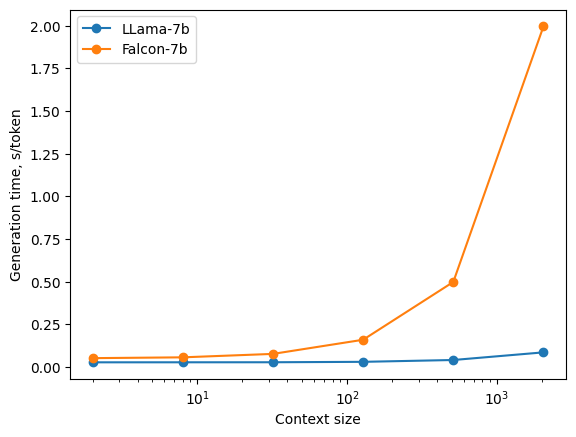

In [194]:
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")
model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-hf")

gc.collect()
torch.cuda.empty_cache()

model.cuda()
words = sample_sequences(tokenizer, ctx_sizes, num_samples=num_samples)
llama2_times = benchmark_times(model, words)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[865.021 852.783 852.879 854.277 854.437 852.25  853.608 854.228 854.248
 854.486 854.753 854.617 854.652 854.3   854.458 851.339 851.764 851.867
 852.261 854.569]
2 854.1398499999999 2.7321540087447396


  0%|          | 0/20 [00:00<?, ?it/s]

[858.804 859.602 858.108 858.664 859.746 857.503 857.24  859.459 859.965
 860.534 859.49  857.362 860.119 859.939 858.623 857.713 860.013 859.864
 857.77  857.435]
8 858.8976500000001 1.0742525436320913


  0%|          | 0/20 [00:00<?, ?it/s]

[872.923 867.81  866.004 866.245 868.264 867.405 866.211 868.706 868.182
 866.686 866.097 866.803 868.314 868.001 868.333 868.648 866.985 867.397
 867.688 865.896]
32 867.6299000000001 1.517902990971426


  0%|          | 0/20 [00:00<?, ?it/s]

[947.373 944.106 945.654 945.987 944.978 944.763 945.364 943.569 943.653
 946.059 945.862 943.393 945.649 946.156 946.07  946.13  946.325 945.611
 943.551 945.88 ]
128 945.3066500000001 1.0870175378070022


  0%|          | 0/20 [00:00<?, ?it/s]

[1293.283 1288.323 1287.887 1289.802 1289.756 1287.974 1294.993 1293.437
 1288.986 1288.679 1288.683 1288.453 1285.588 1288.64  1287.907 1287.579
 1288.51  1288.177 1288.199 1287.001]
512 1289.09285 2.2224130866020193


  0%|          | 0/20 [00:00<?, ?it/s]

[2726.678 2721.384 2721.367 2720.853 2720.966 2721.026 2720.997 2720.683
 2720.757 2720.598 2720.379 2720.446 2720.19  2720.447 2720.339 2720.625
 2720.413 2720.672 2719.857 2720.643]
2048 2720.9659999999994 1.3594367215872698


{2: 852.8782000000001, 8: 858.2537500000001, 32: 865.7991, 128: 944.6195999999998, 512: 1287.85255, 2048: 2720.86755}
{2: 854.1398499999999, 8: 858.8976500000001, 32: 867.6299000000001, 128: 945.3066500000001, 512: 1289.09285, 2048: 2720.9659999999994}
{2: 1636.5505, 8: 1787.7187, 32: 2433.2673999999997, 128: 5085.8624, 512: 15926.935750000004, 2048: 63874.176450000006}


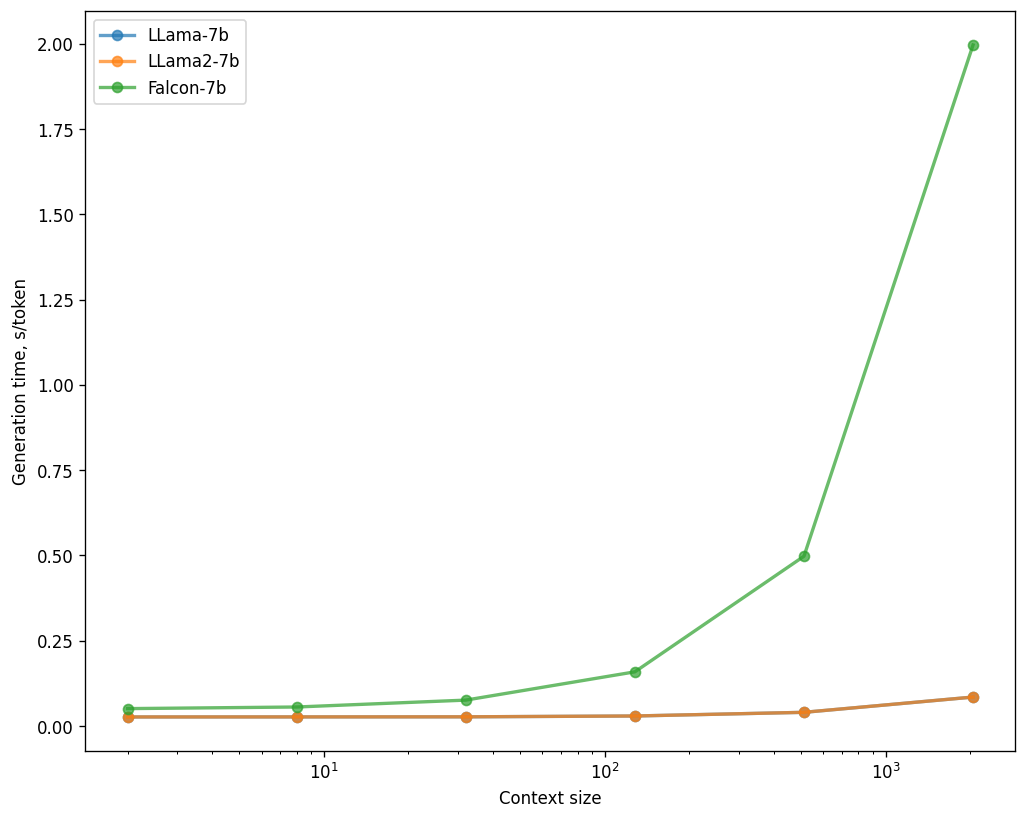

In [218]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-6.9b")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-6.9b")

gc.collect()
torch.cuda.empty_cache()
model.cuda()
words = sample_sequences(tokenizer, ctx_sizes, num_samples=num_samples)
pythia_times = benchmark_times(model, words)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attentio

[1179.569 1165.41  1165.946 1165.366 1165.091 1165.182 1165.631 1165.665
 1166.107 1164.562 1165.645 1165.729 1158.479 1156.423 1155.163 1159.054
 1157.477 1157.999 1158.217 1155.745]
2 1162.9229999999998 5.549343213390195


  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attentio

[1174.866 1173.434 1173.565 1173.913 1173.913 1173.818 1173.076 1174.01
 1172.894 1174.309 1172.902 1173.784 1173.892 1173.715 1174.399 1173.629
 1173.666 1173.595 1173.821 1174.037]
8 1173.7619 0.46354836856577


  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attentio

[1186.125 1178.8   1178.673 1179.236 1177.919 1177.714 1176.551 1177.381
 1177.957 1178.615 1178.76  1177.777 1177.906 1178.632 1178.661 1177.677
 1178.248 1178.625 1177.564 1178.78 ]
32 1178.5800499999998 1.839643266369869


  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attentio

[1273.007 1271.601 1270.514 1270.614 1271.669 1271.535 1271.204 1272.068
 1271.496 1272.82  1271.285 1271.209 1271.799 1272.499 1272.154 1271.872
 1271.75  1272.173 1271.571 1271.938]
128 1271.7389000000003 0.6154730619612893


  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attentio

[1574.709 1566.556 1565.777 1568.424 1566.426 1564.829 1565.473 1567.124
 1566.975 1566.646 1565.815 1568.326 1568.07  1567.659 1568.28  1568.376
 1565.613 1567.999 1567.539 1564.929]
512 1567.2772500000003 2.0603704005590893


  0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attentio

[2957.374 2945.492 2946.365 2949.394 2948.208 2952.36  2956.549 2953.131
 2958.946 2959.568 2959.872 2959.965 2954.567 2948.597 2946.734 2945.532
 2944.392 2943.931 2944.555 2944.169]
2000 2950.9850500000002 5.848363852181235


{2: 852.8782000000001, 8: 858.2537500000001, 32: 865.7991, 128: 944.6195999999998, 512: 1287.85255, 2048: 2720.86755}
{2: 854.1398499999999, 8: 858.8976500000001, 32: 867.6299000000001, 128: 945.3066500000001, 512: 1289.09285, 2048: 2720.9659999999994}
{2: 1162.9229999999998, 8: 1173.7619, 32: 1178.5800499999998, 128: 1271.7389000000003, 512: 1567.2772500000003, 2000: 2950.9850500000002}
{2: 1636.5505, 8: 1787.7187, 32: 2433.2673999999997, 128: 5085.8624, 512: 15926.935750000004, 2048: 63874.176450000006}


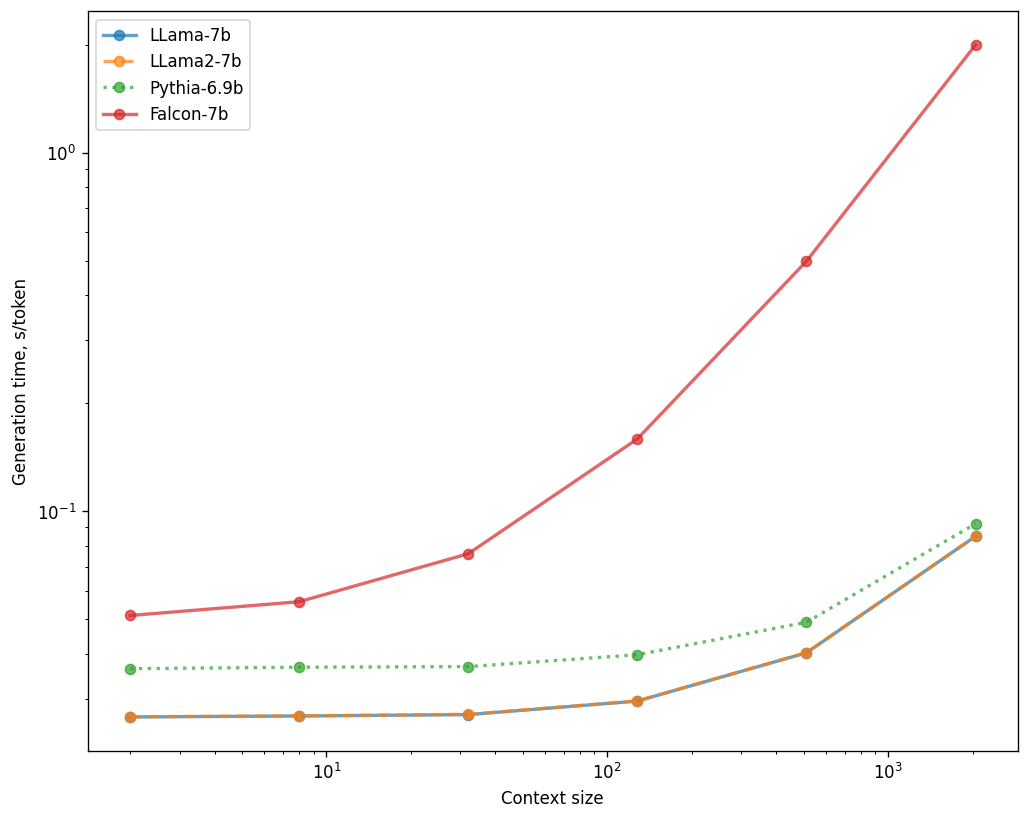

In [221]:
print(llama_times)
print(llama2_times)
print(pythia_times)
print(falcon_times)

def convert(values):
    # return [MAX_NEW_TOKENS * 1000 / v for v in values]
    return [v/1000/MAX_NEW_TOKENS for v in values]

plt.figure(figsize=(10, 8), dpi=120)
plt.plot(llama_times.keys(), convert(llama_times.values()), marker='o', label='LLama-7b', alpha=0.7, linewidth=2)
plt.plot(llama2_times.keys(), convert(llama2_times.values()), marker='o', label='LLama2-7b', alpha=0.7, linewidth=2, linestyle='dashed')
plt.plot(falcon_times.keys(), convert(pythia_times.values()), marker='o', label='Pythia-6.9b', alpha=0.7, linewidth=2, linestyle='dotted')
plt.plot(falcon_times.keys(), convert(falcon_times.values()), marker='o', label='Falcon-7b', alpha=0.7, linewidth=2)
plt.xlabel("Context size")
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Generation time, s/token')
plt.legend()
plt.show()

In [210]:
print("wow")

[2, 8, 32, 128, 512, 2040]